In [433]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import scipy.spatial as sps
import scipy.stats as stats

from cdf import cdf

sys.path.append("../")

In [435]:
import project_utilities as utils
from sequence_analyzer import SequenceAnalyzer

# from sequence_analyzer_copy import SequenceAnalyzer

In [436]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True
prefix = "non_gauss4"

# Load Image

533 800


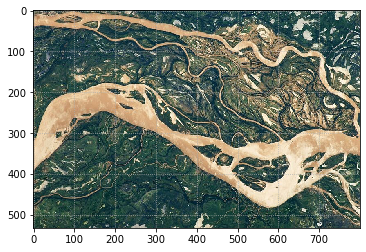

In [437]:
with PIL.Image.open("parana-river-braided-12.jpg") as im:
    Y = np.asarray(im)
    Y = utils.normalize(np.mean(Y, axis=-1) / 255)
    plt.imshow(im)
ny = Y.shape[0]
nx = Y.shape[1]
print(ny, nx)

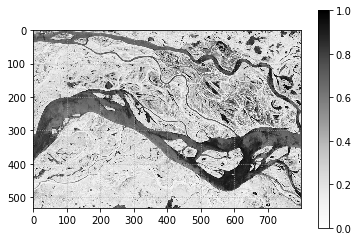

In [438]:
im = plt.imshow(Y, cmap="Greys")
plt.colorbar(im)

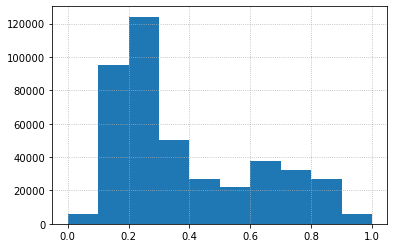

In [439]:
_ = plt.hist(Y.flatten())

In [440]:
# Y = utils.normal_to_lognormal(Y, 1, 2)
# _ = plt.hist(Y.flatten())
# print(Y.mean(), Y.std())

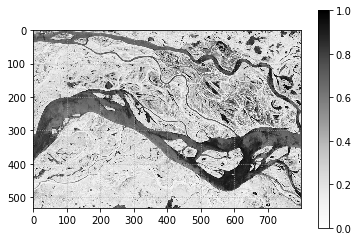

In [441]:
im = plt.imshow(Y, cmap="Greys")
plt.colorbar(im)

# Sample Drillholes

In [442]:
np.random.seed(17)
ndh = 10
ncomps = ny
var = "var"
dhid = "dhid"
comps = pd.DataFrame(index=np.arange(ndh * ncomps), columns=[var])
comps[dhid] = np.repeat(np.arange(ndh), ncomps)
comps = comps[[dhid, var]]
# idxs = np.sort(np.random.randint(0, nx + 1, size=ndh))
idxs = np.linspace(nx / ndh, nx - (nx / ndh), ndh, dtype=int)
for i in range(ndh):
    comps.loc[comps[dhid] == i, var] = Y[:, idxs[i]]
comps = comps.astype({var: float})

'non_gauss4_grid'

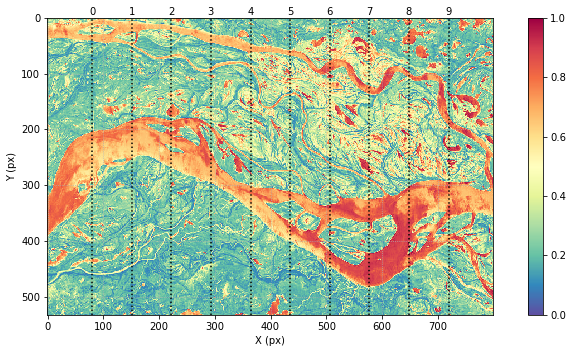

In [443]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y, cmap="Spectral_r")
plt.colorbar(im, ax=ax)
for i, idx in enumerate(idxs):
    ax.axvline(idx, ls=":", c="k")
    ax.text(idx, -5, f"{i}", ha="center")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
utils.savefig(f"{prefix}_grid", bbox_inches="tight")

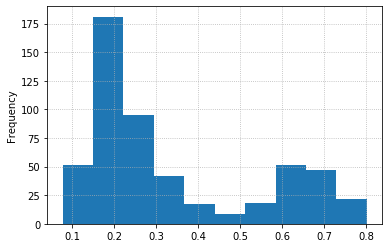

In [444]:
comps.loc[comps[dhid] == 0, var].plot(kind="hist")

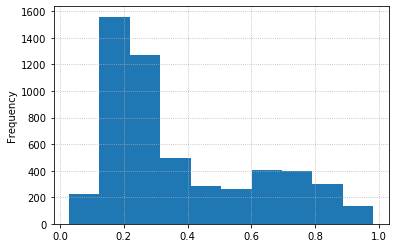

In [445]:
comps[var].plot(kind="hist")

In [446]:
# np.save("dh_nongauss.npy", comps.loc[comps[dhid] == 4, var].values)

# Sequence Analyzer

In [447]:
np.arange(0, 22, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [448]:
sa = SequenceAnalyzer(
    comps,
    dhid,
    var,
    quantiles=np.arange(10, 100, 10),
    scale_factors=[1, 5, 10, 15, 20, 25, 30, 35, 40],
    nreals=100,
    seed=5841044,
    runs_above=True,
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a54aa06c88>)

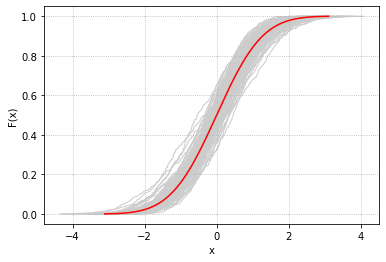

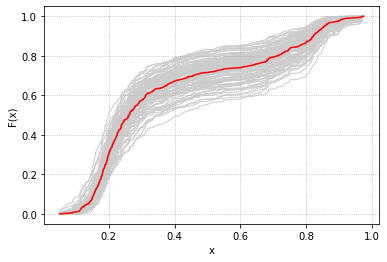

In [449]:
dh = 9
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

# Variogram Test

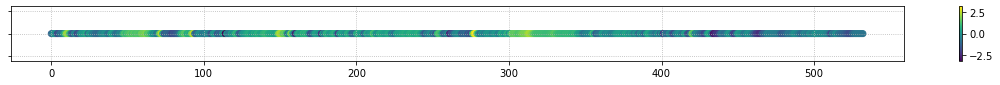

In [450]:
test_dhid = 4
# test_dh = comps.loc[comps[dhid] == test_dhid, var].values
test_dh = sa.dh_dict[test_dhid]["ns_data"]
expvario = sa.oned_variogram(test_dh)
nscorer = sa.dh_dict[test_dhid]["ns_transformer"]
_ = sa.plot_dh(dh=test_dhid)

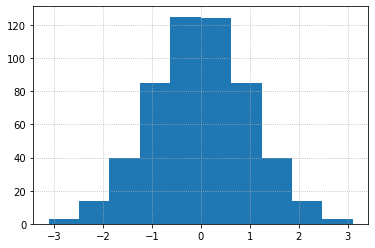

In [451]:
_ = plt.hist(test_dh)

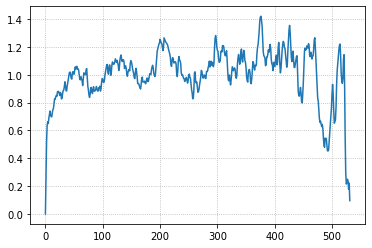

In [452]:
plt.plot(expvario)

In [453]:
def covar(t, d, r):
    """covariance calculation for standard models"""
    h = d / r
    if t == 1:  # Spherical
        c = 1 - h * (1.5 - 0.5 * h ** 2)
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = np.exp(-3 * h ** 2)
    return c

In [454]:
def lusimspherical(d, r, nr, vtype, seed):
    """
    LU matrix simulation for an isotropic variogram
    d: distance matrix
    r: variogram range
    nr: number of realizations
    seed: random number seed
    """
    rng = np.random.default_rng(seed)
    c = covar(vtype, d, r)
    L = np.linalg.cholesky(c)

    # Draw normal random numbers
    if nr == 1:
        x = rng.normal(0, 1, d.shape[0])
    else:
        x = rng.normal(0, 1, [d.shape[0], nr])

    # Correlate with cholesky
    x = L @ x

    return [x, c]

In [455]:
import scipy.spatial as sps

vtype = [2, 2]
xranges = [5, 60]
c0 = 0.0
cc = [0.60, 0.40]
nst = len(vtype)
cova = np.zeros_like(test_dh)
P = np.arange(len(test_dh)) + 0.5
nx = test_dh.shape[0]

for i in range(nst):
    Q = P.copy()
    Q = Q / xranges[i]
    d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
    cova = cova + cc[i] * covar(vtype[i], d, r=1)
target_x = 1 - cova[0:nx, 0]
cx = cova[0:nx, 0]

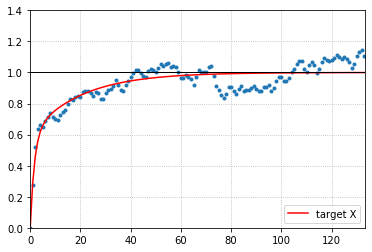

In [456]:
fig, ax = plt.subplots()
ax.plot(expvario, marker=".", ls="None")
ax.plot(target_x, label="target X", c="r")
ax.axhline(1.0, c="k", lw=1)
ax.set_xlim(0, nx * 0.25)
ax.set_ylim(0, 1.4)
ax.legend(loc=4)

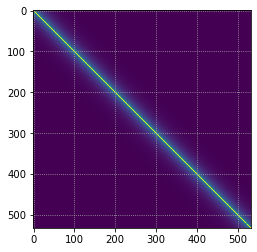

In [457]:
vmin = 0
vmax = 1
plt.imshow(cova, vmin=vmin, vmax=vmax)

In [458]:
# nreals = 100
# Y = np.zeros([len(test_dh), nreals])
# for ns in range(nst):
#     Q = P.copy()
#     Q = Q / xranges[ns]
#     d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
#     sim, cova = lusimspherical(
#         d, r=1, nr=nreals, vtype=vtype[ns], seed=5481044
#     )
#     Y += cc[ns] * sim

# Z = np.zeros_like(Y)
# for ireal in range(sa.nreals):
#     Z[:, ireal] = nscorer.inverse_transform(Y[:, ireal])

In [459]:
# print(Y[:, 1].mean(), Y[:, 1].std())
# _ = plt.hist(Y[:, 1])

In [460]:
# print(Z[:, 0].mean(), Z[:, 0].std())
# _ = plt.hist(Z[:, 0])

In [461]:
# Y_test = np.zeros((len(test_dh), nst))

# for ns in range(nst):
#     Q = P.copy()
#     Q = Q / xranges[ns]
#     d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
#     Y_test[:, ns], cova = lusimspherical(
#         d, r=1, nr=1, vtype=vtype[ns], seed=1044 + ns * 1000
#     )

# print(Y_test[:, 0].mean(), Y_test[:, 0].std())
# print(Y_test[:, 1].mean(), Y_test[:, 1].std())
# _ = plt.hist(Y_test[:, 0])

In [462]:
# Y = Y_test[:, 0] * cc[0] + Y_test[:, 1] * cc[1]
# print(Y.mean(), Y.std())
# _ = plt.hist(Y)

License 832fced2509c9dea checked out by rms_ben to 11c15716e7496a0f expires in 58 minutes. RMSP version 1.8.12 is out of date. There is a new version 1.8.13 featuring optimizations to meshes, as well as a number of other optimizations, improvements, and fixes! Visit https://portal.resourcemodelingsolutions.com to download the updated version. Note that after upgrading this message may not update immediately.
0.3453336278863736 0.20294896698849518


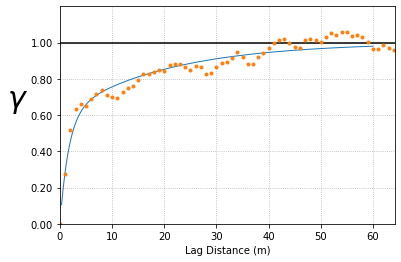

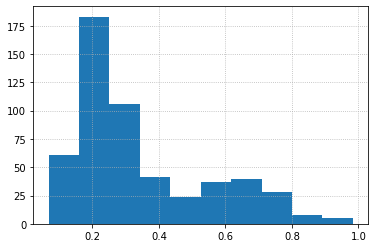

In [463]:
import rmsp

rmsp.activate()

griddef = rmsp.GridDef(
    0,
    0,
    0,
    nu=nx,
    nv=1,
    nz=1,
    usize=1,
    vsize=1,
    zsize=1,
    blockindices=np.arange(nx),
)
grid = rmsp.GridData(griddef=griddef)

vario_dict = dict(
    num_struct=2,
    nugget=0.0,
    shapes=["exponential"] * 2,
    var_contribs=[0.40, 0.60],
    angles=[[90.0, 0.0, 0.0], [90.0, 0.0, 0.0]],
    ranges=[[60, 1, 1], [5, 1, 1]],
)
vario = rmsp.VarioModel(vario_dict)

fig, ax = plt.subplots()
vario.plot(ax=ax)
ax.plot(expvario, marker=".", ls="None")

sim = rmsp.Simulator()
reals = sim.uncond_simulate(grid, vario, reals=100, seed=1044)

Z = np.zeros((nx, sa.nreals))
for i in range(sa.nreals):
    Z[:, i] = nscorer.inverse_transform(reals.get_real(i).values.ravel())

print(Z[:, 0].mean(), Z[:, 0].std())
fig, ax = plt.subplots()
_ = ax.hist(Z[:, 0])

# Continuous Variance

In [464]:
def colorgt(value):
    color = "red" if value >= 3.0 else "k"
    return f"color: {color}"

In [465]:
df = sa.nongauss_measure("scale_continuous")
utils.savetab(df, f"{prefix}_cont_var.tex")
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 5,Scale Factor 10,Scale Factor 15,Scale Factor 20,Scale Factor 25,Scale Factor 30,Scale Factor 35,Scale Factor 40
dhid,,,,,,,,,
0,0.029910,0.775777,0.751091,0.848659,0.809640,0.804310,0.818454,0.849041,0.945368
1,0.218107,0.978219,0.883197,0.994843,0.848277,0.854019,0.940899,0.792259,0.645094
2,0.082819,1.059591,0.919618,1.152279,0.983184,0.761677,0.965204,0.788568,0.981085
3,0.104831,1.257034,1.506231,1.602040,1.384190,1.158901,1.661592,0.810242,1.282938
4,0.070565,1.012327,0.812393,1.035835,1.029459,1.400243,0.752308,0.649306,0.577943
5,0.043640,1.645861,2.518465,1.627303,1.459006,2.001138,1.811624,0.640788,1.793786
6,0.042729,0.468832,0.559273,0.422224,0.562490,0.312306,0.703733,0.313517,0.333627
7,0.048754,0.334608,0.438667,0.482346,0.698483,0.399155,0.844903,1.133531,0.804854
8,0.004342,0.455879,0.336405,0.439147,0.330881,0.679525,0.646654,0.254167,0.213195


In [466]:
# test traditional variogram model
# ds_reals = {f: sa._downsample_realizations(Y, f) for f in sa.scale_factors}
ds_reals = {f: sa._downsample_realizations(Z, f) for f in sa.scale_factors}

cont_var = {f: [] for f in sa.scale_factors}
cont_mean = {f: [] for f in sa.scale_factors}

for f in sa.scale_factors:
    for ireal in range(sa.nreals):
        cont_var[f].append(np.var(ds_reals[f][:, ireal]))
        cont_mean[f].append(np.mean(ds_reals[f][:, ireal]))

df = pd.DataFrame(columns=[f"Scale Factor {f}" for f in sa.scale_factors])
df.index.name = sa.dhid
for f in sa.scale_factors:
    x = sa.dh_dict[test_dhid]["cont_var"][f]
    df.loc[test_dhid, f"Scale Factor {f}"] = np.abs(
        sa.standardize(x, cont_var[f])
    )
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 5,Scale Factor 10,Scale Factor 15,Scale Factor 20,Scale Factor 25,Scale Factor 30,Scale Factor 35,Scale Factor 40
dhid,,,,,,,,,
4,0.282127,0.977924,0.829122,1.239626,1.374301,1.600556,1.139435,0.916345,0.910864


'non_gauss4_reals'

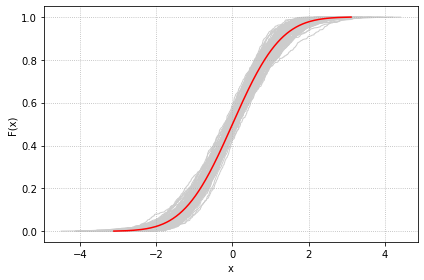

In [467]:
dh = 7
sa.check_reals(dh)
utils.savefig(f"{prefix}_reals")

'non_gauss4_reals_bt'

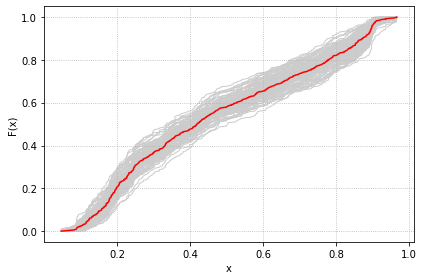

In [468]:
sa.check_reals(dh, gauss=False, log=False)
utils.savefig(f"{prefix}_reals_BT")

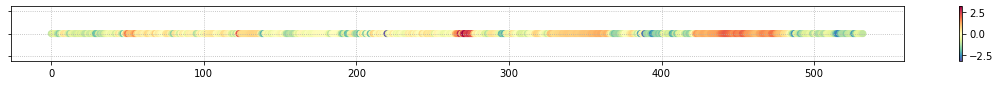

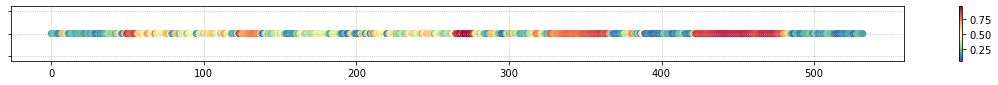

In [469]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss4_cont_var'

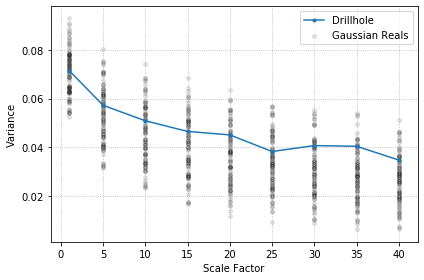

In [470]:
fig, ax = sa.diagnostic_plot("scale_continuous", dh)
# ax.set_ylim(0, 4)
utils.savefig(f"{prefix}_cont_var")

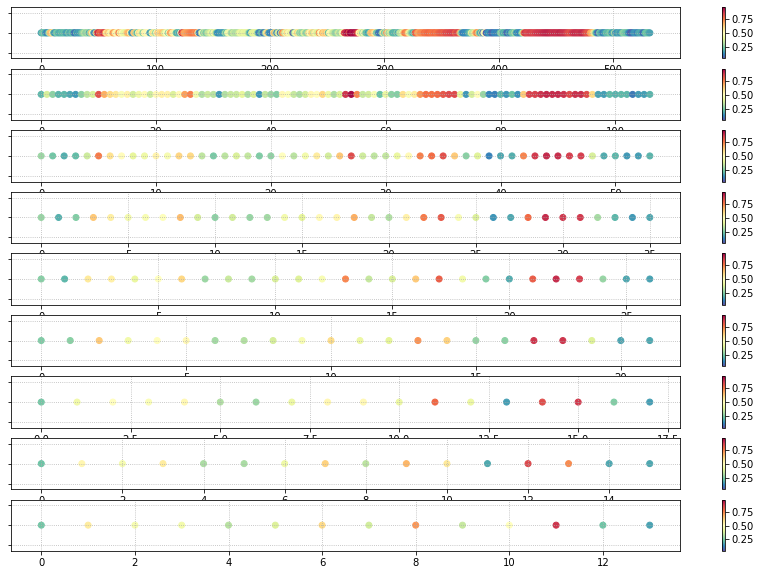

In [471]:
vmin = sa.dh_dict[dh]["x_numpy"].min()
vmax = sa.dh_dict[dh]["x_numpy"].max()

_ = sa.plot_downscaled_dh(dh, cmap="Spectral_r", vmin=vmin, vmax=vmax)

# Total Runs

In [472]:
df = sa.nongauss_measure("total_runs")
utils.savetab(df, f"{prefix}_total_runs.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,1.186521,0.038761,0.977198,1.901874,2.969531,4.565113,7.060086,1.524688,0.247921
1,0.544972,0.359724,0.236363,0.479971,1.263254,3.479513,5.914256,3.533385,0.089290
2,0.654706,0.342152,0.075167,0.017933,0.590002,1.205890,1.934448,1.906741,0.971001
3,0.415348,0.061295,0.160974,1.446378,3.624112,4.884933,6.953002,6.656387,0.558654
4,0.720548,0.215832,0.457860,1.256479,2.593484,4.105253,5.872509,2.706938,0.043612
5,1.182826,0.822388,0.311235,1.180254,2.436493,2.850894,6.652730,3.146159,2.459775
6,1.315056,1.209054,0.301048,0.282460,0.261271,0.252911,1.428606,2.832302,0.757450
7,1.220012,0.904961,0.177874,0.248162,0.547028,1.184196,2.387658,3.958505,5.133028
8,0.871370,1.110133,0.703340,0.235138,0.362527,0.995847,2.614601,5.015829,1.422922


In [473]:
df.max()

0.1 Indicator    1.315056
0.2 Indicator    1.209054
0.3 Indicator    0.977198
0.4 Indicator    1.901874
0.5 Indicator    3.624112
0.6 Indicator    4.884933
0.7 Indicator    7.060086
0.8 Indicator    6.656387
0.9 Indicator    5.133028
dtype: float64

In [474]:
# test traditional variogram model
ind_reals = sa._realization_indicator_transform(Z)
# ind_reals = sa._realization_indicator_transform(Z, sa.dh_dict[test_dhid]["thresholds"])

runs_reals = {
    q / 100: sa._binary_runs_realizations(ind_reals[q / 100])
    for q in sa.quantiles
}

df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid
for q, t in sa.thresholds.items():
    tot_runs = []
    for ireal in range(sa.nreals):
        tot_runs.append(len(runs_reals[q]["cum_runs"][ireal]))
    x = len(sa.dh_dict[test_dhid]["runs"][q]["cum_runs"])
    df.loc[test_dhid, f"{q} Indicator"] = np.abs(sa.standardize(x, tot_runs))
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
4,0.497131,0.085175,0.573288,1.202680,2.368415,3.680577,4.694656,2.105788,0.137808


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a5842a7e48>)

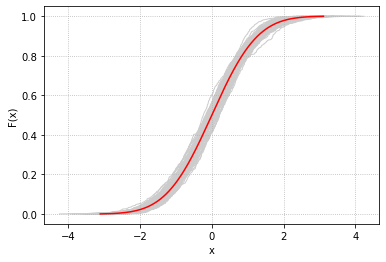

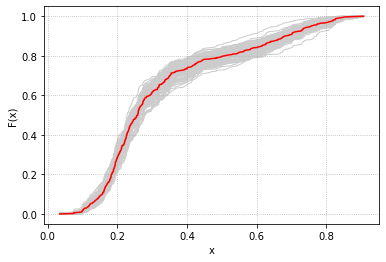

In [475]:
dh = 5
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

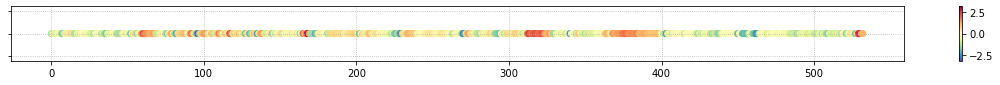

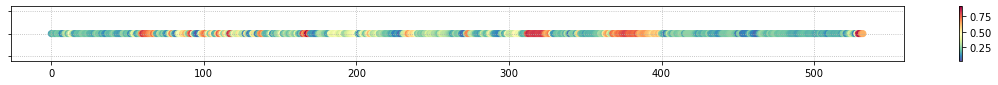

In [476]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss4_total_runs'

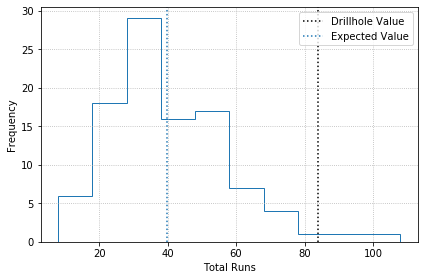

In [477]:
q = 0.9
_ = sa.diagnostic_plot("total_runs", dh, q)
utils.savefig(f"{prefix}_total_runs")

'non_gauss4_indicators'

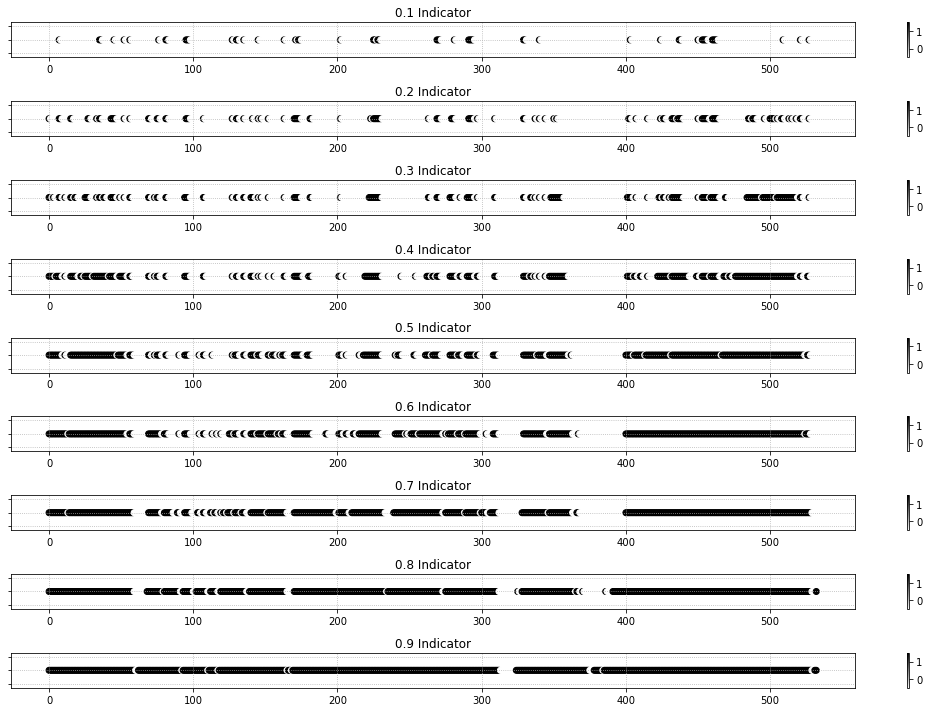

In [478]:
fig, ax = sa.plot_indicators(dh, cmap="binary", figsize=(15, 10))
fig.tight_layout()
utils.savefig(f"{prefix}_indicators")

# Cumulative Runs

In [479]:
df = sa.nongauss_measure("run_length_freqs", max_runs=30)
utils.savetab(df, f"{prefix}_run_length_freqs.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,1.455905,0.228047,0.542306,1.116243,1.861374,3.029355,4.670668,1.553088,0.197786
1,0.329341,0.308366,0.356109,0.392086,1.127302,3.269491,5.947458,6.127608,0.052787
2,0.673953,0.096772,0.210434,0.290936,0.894971,1.563412,2.338654,2.458724,1.379183
3,0.687751,0.112161,0.281131,1.162527,3.266815,4.986418,8.456894,8.223188,1.030952
4,0.603378,0.481400,0.326550,1.180085,2.674398,4.780431,7.413382,3.110716,0.136492
5,1.241588,0.923594,0.378072,1.103356,2.245010,2.600214,600011.906034,3.156245,5.787438
6,1.226154,1.074976,0.118264,0.604467,0.534126,0.419917,1.397243,2.737275,0.958380
7,1.228848,0.971623,0.244466,0.229040,0.557852,0.869914,1.901413,3.356452,4.745663
8,1.158017,1.451260,1.239022,0.599105,0.086085,0.626508,1.622757,2.863652,1.509352


In [480]:
df.max()

0.1 Indicator         1.455905
0.2 Indicator         1.451260
0.3 Indicator         1.239022
0.4 Indicator         1.180085
0.5 Indicator         3.266815
0.6 Indicator         4.986418
0.7 Indicator    600011.906034
0.8 Indicator         8.223188
0.9 Indicator         5.787438
dtype: float64

In [481]:
# test traditional variogram
max_runs = 30
df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid

for q, t in sa.thresholds.items():
    dh_runs = sa.dh_dict[test_dhid]["runs"][q]["cum_runs_freqs"]
    nruns = min(len(dh_runs), max_runs)
    temp = np.zeros((sa.nreals, len(sa.dh_dict[test_dhid]["x_numpy"])))
    for ireal in range(sa.nreals):
        real_run_freqs = runs_reals[q]["cum_runs_freqs"][ireal]
        idxs = np.arange(len(real_run_freqs))
        temp[ireal, idxs] = real_run_freqs
    x = dh_runs[:nruns]
    d = temp[:, :nruns]
    scores = [sa.standardize(x[i], d[:, i]) for i in range(nruns)]
    score = np.mean(np.abs(scores))
    df.loc[test_dhid, f"{q} Indicator"] = score
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
4,0.439884,0.371073,0.500380,1.140756,2.589478,4.431254,6.030148,2.450631,0.229746


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a5845bf308>)

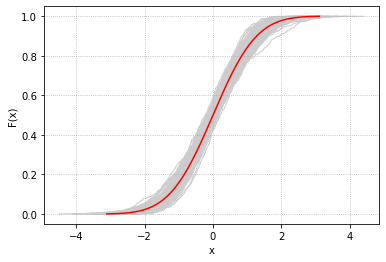

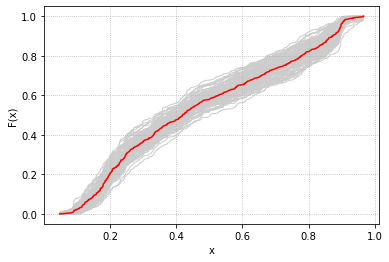

In [482]:
dh = 7
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

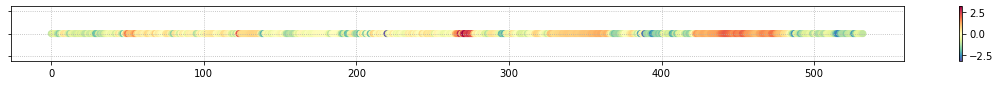

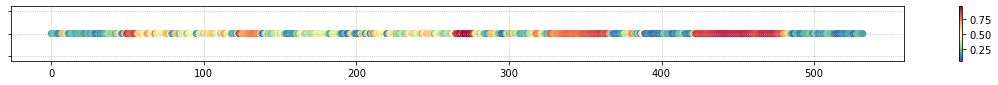

In [483]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss4_run_length_freqs'

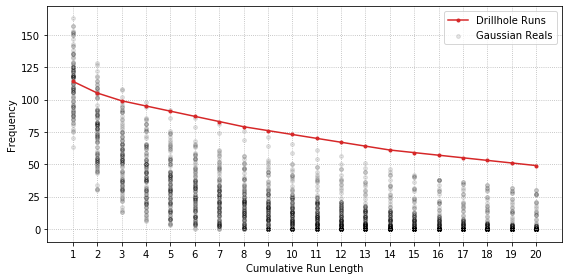

In [486]:
q = 0.9
f = None
max_runs = 20
figsize = (8, 4)
fig, ax = sa.diagnostic_plot(
    "run_length_freqs", dh, q, max_runs=max_runs, figsize=figsize
)
# ax.set_ylim(top=40)
utils.savefig(f"{prefix}_run_length_freqs")

# h-Scatter

0.6031870075576548


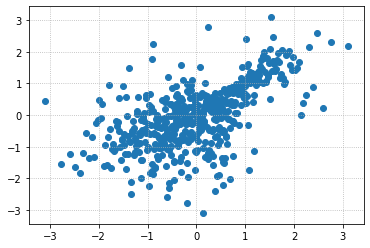

In [378]:
# h-scatter
dh = 7
x = sa.dh_dict[dh]["ns_data"]
array = np.asarray(x)
nx = array.shape[0]
cx = np.zeros(nx - 1)
h = 5
for i in range(1, h):
    z0 = array[0 : nx - i]
    z1 = array[i:nx]
    dz = (z1 * z0) - np.mean(z0) * np.mean(z1)
    cx[i] = np.sum(dz) / (nx - i)
plt.scatter(z0, z1)
print(np.cov(z0, z1)[0, 1])

0.15500945179584122
0.06049149338374291


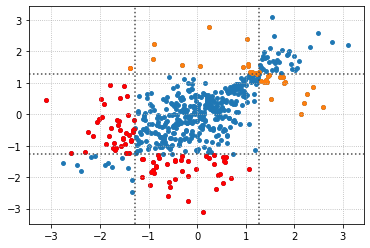

In [379]:
thresh = 1.28
mask1 = ((z0 < -thresh) & (z1 >= -thresh)) | ((z0 >= -thresh) & (z1 < -thresh))
mask2 = ((z0 < thresh) & (z1 >= thresh)) | ((z0 >= thresh) & (z1 < thresh))
fig, ax = plt.subplots()
ax.scatter(z0, z1, s=15)
ax.scatter(z0[mask1], z1[mask1], c="r", s=15)
ax.scatter(z0[mask2], z1[mask2], c="C1", s=15)
ax.axvline(thresh, c="0.3", ls=":")
ax.axhline(thresh, c="0.3", ls=":")
ax.axvline(-thresh, c="0.3", ls=":")
ax.axhline(-thresh, c="0.3", ls=":")
print(len(z0[mask1]) / len(z0))
print(len(z0[mask2]) / len(z0))

# n-Point Connectivity

In [221]:
nstep = 20
df = sa.nongauss_measure("n_pt_connectivity", nstep=nstep)
utils.savetab(df, f"{prefix}_n_pt_connectivity.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.451309,0.241656,0.192505,0.485522,0.923360,1.184310,2.732031,1.500989,0.110699
1,0.366601,0.385730,0.236602,0.615144,0.553439,0.917880,1.482912,0.608937,0.056594
2,0.167745,0.313049,0.417404,0.302963,0.593898,0.549622,1.204017,1.950579,1.026585
3,0.317955,0.341569,0.240752,0.316929,0.572092,0.822625,1.983901,2.249696,0.549946
4,0.221051,0.261723,0.200442,0.283205,1.254993,1.618085,1.425637,1.432950,0.089293
5,0.263026,0.605414,0.295106,1.690905,2.850759,3.147103,2.500178,2.520700,0.966997
6,0.394326,0.212323,0.394675,0.320708,0.818291,1.123475,1.112106,1.199199,1.480512
7,0.377473,0.378995,0.449838,0.507438,0.309930,0.854325,0.729554,1.066568,2.993625
8,0.184532,0.354896,0.501314,0.593492,0.332620,0.163644,0.776536,1.546851,1.133623


'non_gauss4_n_pt_connectivity'

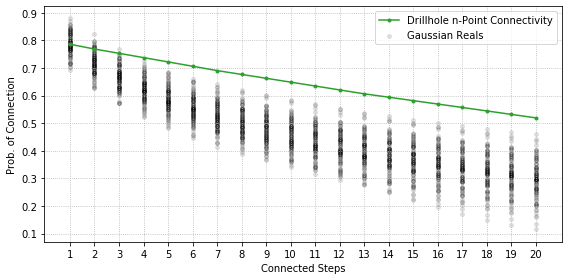

In [485]:
dh = 7
q = 0.9
f = None
max_runs = None

figsize = (8, 4)
fig, ax = sa.diagnostic_plot(
    "n_pt_connectivity", dh, q, f, max_runs, nstep, figsize
)
# ax.set_ylim(top=1.0)
utils.savefig(f"{prefix}_n_pt_connectivity")

In [360]:
sa.runs_above

True

In [361]:
x = sa.dh_dict[dh]["indicators"][f"{q} Indicator"].values
dh_conn = sa.n_pt_conn(1-x, nstep)
temp = np.zeros((sa.nreals, nstep))
for ireal in range(sa.nreals):
    ind_real = sa.dh_dict[dh]["ind_reals"][q][:, ireal]
    temp[ireal, :] = sa.n_pt_conn(1-ind_real, nstep)
scores = [sa.standardize(dh_conn[i], temp[:, i]) for i in range(nstep - 1)]

In [362]:
for i, s in enumerate(scores):
    print(i, s)

0 0.04121796605457431
1 1.2462983359883024
2 1.886282749234959
3 2.3299940636075545
4 2.697752522835205
5 3.007564551721013
6 3.26621915759295
7 3.4861231313828123
8 3.7291220582890072
9 3.950302344920994
10 4.142646671362635
11 4.305014156962806
12 4.447553475356535
13 4.570719830610565
14 4.7671018084003425
15 4.957922738618224
16 5.1456374780303085
17 5.351462688770339
18 5.574377410798234


In [363]:
np.mean(np.abs(scores))

3.62649016529144

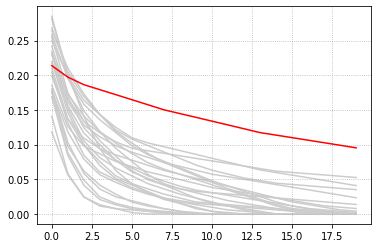

In [364]:
plt.plot(dh_conn, c="r")
for i in range(25):
    plt.plot(temp[i, :], c="0.8", zorder=-1)

In [336]:
(dh_conn[-1] - np.mean(temp[:, -1])) / np.std(temp[:, -1])

5.766456265824125

In [337]:
dh_conn[-1], np.mean(temp[:, -1]), np.std(temp[:, -1])

(0.09533073929961089, 0.007412451361867705, 0.015246502164389199)

In [229]:
dh = 5
ind = sa.dh_dict[dh]["indicators"]["0.5 Indicator"].values


# def n_pt_conn(x):
#     nx = len(x)
#     cx = np.zeros(nx - 1)
#     for i in range(1, nx - 1):
#         z0 = x[0 : nx - i]
#         z1 = x[i:nx]
#         dz = z1 * z0
#         cx[i] = np.mean(dz)
#     return cx


# def n_pt_conn(x, nstep):
#     nx = len(x)
#     phi_n = []
#     for n in range(1, nstep+1):
#         for i in range(0, n):
#             h0 = x[0 : nx - i]
#             h1 = x[i:nx]
#         phi_n.append(np.mean(h0 * h1))
#     return phi_n

In [230]:
# np.random.seed(66)
np.random.seed(99)

nx = 500
x = np.random.randint(0, 2, size=nx)
ntot = 20
print(x)

[1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1
 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0
 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0
 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0
 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0
 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1
 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0
 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 

In [231]:
phi_n = []
for n in range(1, ntot + 1):
    prod = []
    for i in range(nx - n + 1):
        idxs = [i] + [j + i for j in range(n)]
        a = [x[idx] for idx in idxs]
        prod.append(np.prod(a))
    #         print(idxs, a)
    phi_n.append(np.mean(prod))

In [232]:
def n_pt_conn(x, nstep):
    """n-point connectivity fucntion of binary array x"""
    x = np.asarray(x)
    nx = x.shape[0]
    phi_n = []
    for n in range(1, nstep + 1):
        prod = []
        for i in range(nx - n + 1):
            idxs = [i] + [j + i for j in range(n)]
            a = [x[idx] for idx in idxs]
            prod.append(np.prod(a))
        phi_n.append(np.mean(prod))
    return phi_n

In [233]:
n_pt_conn(sa.dh_dict[dh]["indicators"][f"{q} Indicator"].values, 30)

[0.5722326454033771,
 0.48120300751879697,
 0.4105461393596987,
 0.35471698113207545,
 0.31568998109640833,
 0.2859848484848485,
 0.25996204933586337,
 0.24334600760456274,
 0.22857142857142856,
 0.21374045801526717,
 0.20267686424474188,
 0.19157088122605365,
 0.18042226487523993,
 0.16923076923076924,
 0.16184971098265896,
 0.15444015444015444,
 0.1470019342359768,
 0.13953488372093023,
 0.13398058252427184,
 0.12840466926070038,
 0.12280701754385964,
 0.1171875,
 0.11154598825831702,
 0.10588235294117647,
 0.10019646365422397,
 0.09448818897637795,
 0.08875739644970414,
 0.08300395256916997,
 0.07722772277227723,
 0.07142857142857142]

In [234]:
# # multiply expected product of indicators for all n steps
# EI = []
# for n in range(1, ntot+1):
#     for i in range(0, n):
#         z0 = x[0 : nx - i]
#         z1 = x[i:nx]

#         print(f"\nx[0:{nx-i}]", z0)
#         print(f"x[{i}:{nx}]", z1)

#     EI.append(np.mean(z0 * z1))

#     print("\n", EI)
#     test.append(EI)

# # n_pt_conn(test_x, ntot)

In [235]:
sa.dh_dict[dh]["ind_reals"][q].shape

(533, 100)

'n_pt_connectivity'

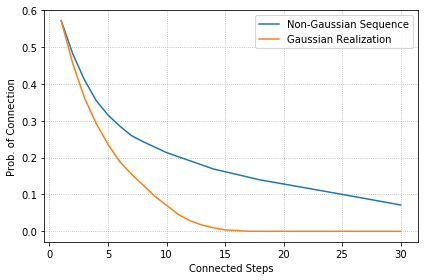

In [236]:
dh = 5
nlags = 30
ireal = 2
q = 0.5
x = np.arange(nlags) + 1
fig, ax = plt.subplots()
ax.plot(
    x,
    n_pt_conn(sa.dh_dict[dh]["indicators"][f"{q} Indicator"].values, nlags),
    label="Non-Gaussian Sequence",
)
ax.plot(
    x,
    n_pt_conn(sa.dh_dict[dh]["ind_reals"][q][:, ireal], nlags),
    label="Gaussian Realization",
)
ax.set_xlabel("Connected Steps")
ax.set_ylabel("Prob. of Connection")
# ax.set_xticklabels(x)
ax.legend()
utils.savefig("n_pt_connectivity")

In [237]:
sa.dh_dict[dh].keys()

dict_keys(['x_numpy', 'x_pandas', 'ds_x', 'indicators', 'ds_indicators', 'runs', 'ns_transformer', 'ns_data', 'gauss_reals', 'reals', 'ind_reals', 'runs_reals', 'ds_reals', 'ds_ind_reals', 'cont_var', 'cont_means', 'sim_cont_var', 'sim_cont_means'])